In [2]:
# =====================
# 1. Artificial Data Generation with Enhanced Randomness
# =====================

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
train_df = pd.read_csv('../Data/database/traintripper_trains.csv')
fare_df = pd.read_csv('../Data/processed_data/all_no_fare_analysis.csv')
def generate_artificial_bookings(train_df, fare_df, num_days=60):
    np.random.seed(42)
    artificial_data = []
    
    # Create random journey dates for each train
    journey_dates = {
        train['train_number']: datetime(2025, 4, 1) + timedelta(days=random.randint(0, 30))
        for _, train in train_df.iterrows()
    }
    
    for _, train in train_df.iterrows():
        train_number = train['train_number']
        station_from = train['station_from']
        station_to = train['station_to']
        classes = fare_df[fare_df['trainNumber'] == train_number]['classCode'].unique()
        
        for class_code in classes:
            base_fare = fare_df[(fare_df['trainNumber'] == train_number) & 
                               (fare_df['classCode'] == class_code)]['totalFare'].values[0]
            
            # Enhanced booking pattern with variable growth rates and random surges
            capacity = 480
            x = np.linspace(-6, 6, num_days)
            
            # Randomize growth parameters based on route and class
            growth_rate = np.random.uniform(0.1, 3.5)  # Vary growth rate
            surge_day = random.choice([None, 7, 14, 21, 28])  # Random surge days
            surge_intensity = random.uniform(1.2, 1.8) if surge_day else 1
            
            bookings = (capacity / (1 + np.exp(-x * (growth_rate*(1 + np.exp(-x))))))
            
            # Add random noise and surges
            noise = np.random.normal(0, 15, num_days)
            if surge_day:
                surge_window = slice(max(0, surge_day-3), min(num_days, surge_day+3))
                bookings[surge_window] *= surge_intensity
                
            bookings = np.clip(bookings + noise, 0, capacity*1.2).astype(int)
            
            # Initialize waitlist dictionary
            waitlist_dict = {}
            
            for day in range(num_days):
                days_remaining = num_days - day
                seats_sold = min(bookings[day], capacity)
                available_seats = capacity - seats_sold
                waitlist = max(0, bookings[day] - capacity)
                
                # Store in dictionary (negative = available seats, positive = waitlist)
                waitlist_dict[days_remaining] = -available_seats if available_seats > 0 else waitlist
                
            # Create single record per journey with full timeline
            record = {
                'train_number': train_number,
                'station_from': station_from,
                'station_to': station_to,
                'class_code': class_code,
                'base_fare': base_fare,
                'journey_date': journey_dates[train_number].strftime('%Y-%m-%d'),
                'booking_pattern': waitlist_dict,
                'growth_rate': growth_rate,
                'surge_day': surge_day if surge_day else -1,
                'total_demand': bookings[-1]  # Final demand at departure
            }
            artificial_data.append(record)
    
    return pd.DataFrame(artificial_data)

# Generate the dataset
artificial_data = generate_artificial_bookings(train_df, fare_df)
artificial_data.to_csv('enhanced_train_data.csv', index=False)

# Show sample output
print(artificial_data[['train_number', 'class_code', 'journey_date', 
                      'growth_rate', 'surge_day', 'booking_pattern']].head(2))


/tmp/ipykernel_464/2347105706.py:40: RuntimeWarning: overflow encountered in exp
  bookings = (capacity / (1 + np.exp(-x * (growth_rate*(1 + np.exp(-x))))))


   train_number class_code journey_date  growth_rate  surge_day  \
0          1027         2A   2025-04-08     1.373436         28   
1          1027         3A   2025-04-08     1.705531         28   

                                     booking_pattern  
0  {60: -480, 59: -476, 58: -476, 57: -465, 56: -...  
1  {60: -475, 59: -480, 58: -475, 57: -457, 56: -...  


In [3]:
print(artificial_data['total_demand'].max())
print(artificial_data['total_demand'].min())
print(artificial_data['total_demand'].mean())




523
291
470.7184160905091


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.pipeline import Pipeline
import ast

# =====================
# Data Parsing
# =====================

def safe_parse_booking_pattern(s):
    """Convert string representation of dict to actual dict"""
    try:
        s = str(s).replace('np.int64', '').replace('(', '').replace(')', '')
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return {}

# =====================
# Feature Engineering
# =====================

def extract_demand_features(booking_pattern):
    current_day= min(booking_pattern.keys())
    """Extract predictive features from partial booking pattern"""
    if not isinstance(booking_pattern, dict):
        return {}
        
    return {
        'current_status': booking_pattern.get(current_day, 0),
        'bookings_last_week': sum(1 for d in range(current_day, current_day+7) 
                                 if booking_pattern.get(d, 0) < 0),
        'waitlist_growth': sum(booking_pattern.get(d, 0) 
                              for d in range(max(1, current_day-3), current_day+1)
                              if booking_pattern.get(d, 0) > 0),
        'early_booking_rate': sum(1 for d in range(current_day+20, 61) 
                                 if booking_pattern.get(d, 0) < 0) / max(1, 60 - (current_day+20)),
        'recent_occupancy_trend': np.nanmean([booking_pattern.get(d, 0) 
                                           for d in range(max(1, current_day-7), current_day+1)]),
        'current_day': current_day
    }

# =====================
# Model Pipeline
# =====================

def prepare_training_data(df):
    """Process raw data into training format"""
    processed_data = []
 
    for _, row in df.iterrows():
        for q in range(10):
            booking_pattern= row['booking_pattern']
            current_day = random.randint(0, 30)
            filtered_booking_pattern = {k: v for k, v in booking_pattern.items() if k >= current_day}
            features = extract_demand_features(filtered_booking_pattern)
            record = {
                'train_number': row['train_number'],
                'station_from': row['station_from'],
                'station_to': row['station_to'],
                'class_code': row['class_code'],
                'base_fare': row['base_fare'],
                **features,
                'total_demand': row['total_demand']
            }
            processed_data.append(record)
    
    return pd.DataFrame(processed_data)

def train_demand_model(train_df):
    """Train complete demand prediction model"""
    df = prepare_training_data(train_df)
    
    numeric_features = ['base_fare', 'bookings_last_week', 'waitlist_growth',
                       'early_booking_rate', 'recent_occupancy_trend']
    categorical_features = ['station_from', 'station_to', 'class_code']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', 'passthrough', numeric_features)
        ])
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42))
    ])
    
    X = df.drop('total_demand', axis=1)
    y = df['total_demand']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    return model, X_test, y_test



# Load and parse data
train_df = pd.read_csv('enhanced_train_data.csv')
train_df['booking_pattern'] = train_df['booking_pattern'].apply(safe_parse_booking_pattern)

# Train model
model, X_test, y_test = train_demand_model(train_df)






In [5]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score on test set: {r2}")

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test set: {rmse}")

R2 Score on test set: 0.7646711575315808
RMSE on test set: 15.544774336404837


In [6]:
# =====================
# Usage Example
# =====================

# Sample prediction input
input_data = {
    'train_number': 2134,
    'station_from': 'JBP',
    'station_to': 'BDTS',
    'class_code': 'SL',
    'base_fare': 415,
    'booking_pattern': {60: np.int64(-480), 59: np.int64(-473), 58: np.int64(-473), 57: np.int64(-460), 56: np.int64(-480), 55: np.int64(-476), 54: np.int64(-480), 53: np.int64(-478), 52: np.int64(-474), 51: np.int64(-480), 50: np.int64(-480), 49: np.int64(-476), 48: np.int64(-475), 47: np.int64(-480), 46: np.int64(-480), 45: np.int64(-457), 44: np.int64(-468), 43: np.int64(-470), 42: np.int64(-467), 41: np.int64(-437), 40: np.int64(-376), 39: np.int64(-364), 38: np.int64(-346), 37: np.int64(-306), 36: np.int64(-307), 35: np.int64(-197), 34: np.int64(-183), 33: np.int64(-198), 32: np.int64(-191), 31: np.int64(-213), 30: np.int64(-189), 29: np.int64(-254), 28: np.int64(-229), 27: np.int64(-233), 26: np.int64(-245), 25: np.int64(-227), 24: np.int64(-213), 23: np.int64(-210), 22: np.int64(-244)}
}

# Prepare input features
features = extract_demand_features(input_data['booking_pattern'])
prediction_input = pd.DataFrame([{**input_data, **features}])

# Make prediction
predicted_demand = model.predict(prediction_input)[0]
print(f"Predicted Total Demand: {predicted_demand:.0f} seats")


Predicted Total Demand: 353 seats


Epoch 1/50


/home/yashu1819/dynamicPricingTrains/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1045.0416 - mae: 18.8427 - val_loss: 963.4084 - val_mae: 18.1668
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1131.8134 - mae: 19.7179 - val_loss: 950.9371 - val_mae: 18.0781
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1170.3484 - mae: 19.3967 - val_loss: 935.3925 - val_mae: 17.9743
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1045.7579 - mae: 19.3213 - val_loss: 925.4838 - val_mae: 17.9060
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1040.7347 - mae: 18.6611 - val_loss: 915.9703 - val_mae: 17.8389
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1097.6033 - mae: 19.1730 - val_loss: 906.5335 - val_mae: 17.7729
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 940.9826 - mae: 18.3087 - val_loss: 898.6148 - val_mae: 17.7188
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 948.3826 - mae: 18.3282 - val_loss: 889.7632 - val_mae: 17.6544
Epoch 9/50
40/40 ━━━━

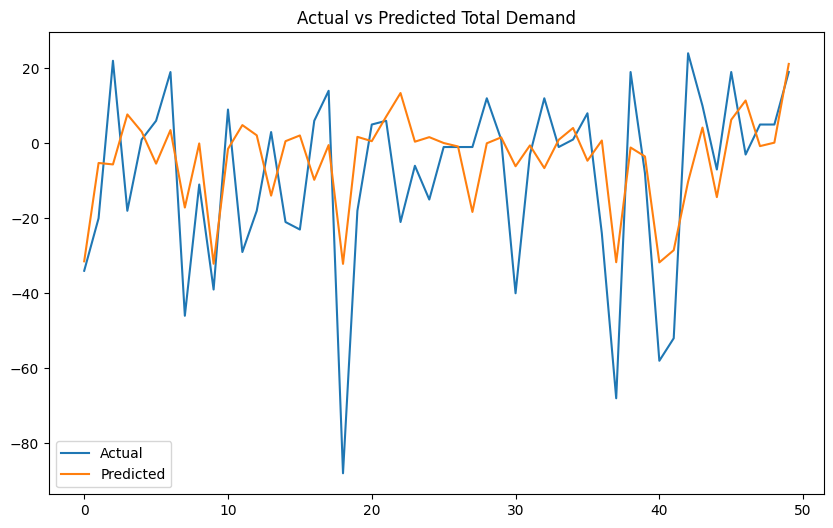

In [9]:
# Can I use LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

df=train_df.copy()

# def train_for_days_remaining(current_day):
# Extract sequences and total demand
X = []
y = []

for _, row in df.iterrows():
    booking_pattern = row['booking_pattern']
    sequence = [v for k, v in reversed(sorted(booking_pattern.items())) if k>=20]  # Sorted by day (keys)
    X.append(sequence)
    y.append(row['total_demand']-480)

X = np.array(X)  # Shape: (samples, timesteps)
y = np.array(y)  # Shape: (samples,)


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Reshape X to have a third dimension (features=1 since we only have availability/waitlist as input)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# Define LSTM model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(60, 1), return_sequences=False),  # One LSTM layer
    Dense(1)  # Output layer for predicting total_demand
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Compare predictions with actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test[:50], label='Actual')
plt.plot(y_pred[:50], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Total Demand")
plt.show()


